<a href="https://colab.research.google.com/github/therishabhmittal-05/camera/blob/main/Semantic_Segmentation/UNet_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn, optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super().__init__()
    self.doubleconv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.doubleconv(x)

In [ ]:
class DownSample(nn.Module):
  def __init__(self):
    super().__init__()
    self.downsample = nn.MaxPool2d(2)
  def forward(self, x):
    return self.downsample(x)

In [ ]:
class UpSample(nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super().__init__()
    self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
  def forward(self, x):
    return self.upsample(x)

In [ ]:
class CropandConcat(nn.Module):
  def forward(self, x, contract_x):
    contract_x = torchvision.transforms.functional.center_crop(contract_x, (x.shape[2], x.shape[3]))
    return torch.cat([x, contract_x], dim=1)

In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super().__init__()
    self.downconv = nn.ModuleList(
        [DoubleConv(i, o) for i, o in [(in_channels, 64), (64, 128), (128, 256), (256, 512)]]
    )
    self.downsample = nn.ModuleList(
       [DownSample() for _ in range(4)]
    )

    self.middleconv = DoubleConv(512, 1024)
    self.upsample = nn.ModuleList(
        [UpSample(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]]
    )
    self.upconv = nn.ModuleList(
        [DoubleConv(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]]
    )
    self.concat = nn.ModuleList(
        [CropandConcat() for _ in range(4)]
    )
    self.finalconv = nn.Conv2d(64, out_channels, kernel_size=1)

  def forward(self, x):
    pass_contract = []
    for i in range(len(self.downconv)):
      x = self.downconv[i](x)
      pass_contract.append(x)
      x = self.downsample[i](x)
    x = self.middleconv(x)
    for i in range(len(self.upconv)):
      x = self.upsample[i](x)
      x = self.concat[i](x, pass_contract.pop())
      x = self.upconv[i](x)
    return self.finalconv(x)

In [ ]:
model = Unet(3, 3).to(device)
model


Unet(
  (downconv): ModuleList(
    (0): DoubleConv(
      (doubleconv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): DoubleConv(
      (doubleconv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): DoubleConv(
      (doubleconv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): DoubleConv(
      (doubleconv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [ ]:
from torchsummary import summary
summary(model, (64, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          36,928
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
        DoubleConv-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
        DownSample-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
             ReLU-11        [-1, 128, 128, 128]               0
       DoubleConv-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 64, 64]               0
       DownSample-14          [-1, 128,

In [2]:
!wget --directory-prefix=/content/drive/MyDrive/COCO_StuffThing http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip


--2025-04-23 06:28:11--  http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip
Resolving calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)... 129.215.202.26
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip [following]
--2025-04-23 06:28:11--  https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip [following]
--2025-04-23 06:28:12--  https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip
Resolvin

In [3]:
import zipfile
from pathlib import Path

with zipfile.ZipFile("/content/drive/MyDrive/COCO_StuffThing/val2017.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/COCO_StuffThing")

In [4]:
with zipfile.ZipFile("/content/drive/MyDrive/COCO_StuffThing/stuffthingmaps_trainval2017.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/COCO_StuffThing")

In [1]:
# ! wget http://images.cocodataset.org/zips/val2017.zip

--2025-04-23 14:30:20--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.92, 3.5.27.80, 16.15.184.14, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  56.5MB/s    in 16s     

2025-04-23 14:30:37 (47.4 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [2]:
# !unzip /content/val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

[]

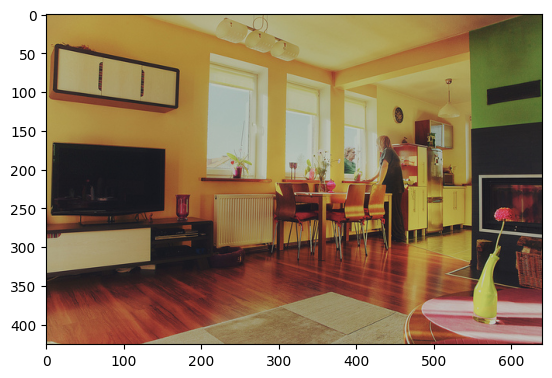

In [2]:
import matplotlib.pyplot as plt
img = plt.imread("/content/val2017/000000000139.jpg")
plt.imshow(img)
plt.plot()

In [7]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-04-23 14:34:01--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.97.44, 52.217.108.204, 52.216.56.225, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.97.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  58.5MB/s    in 4.6s    

2025-04-23 14:34:06 (52.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [8]:
!unzip /content/annotations_trainval2017.zip

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
import json
with open("/content/annotations/instances_val2017.json") as f:
  data = json.load(f)
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [4]:
data["images"][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [5]:
data["annotations"][0]

{'segmentation': [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.35,
   414.93,
   479.86,
   418.65,
   477.32,
   420.03,
   476.04,
   422.58,
   479.02,
   422.58,
   480.29,
   423.01,
   483.79,
   419.93,
   486.66,
   416.21,
   490.06,
   415.57,
   492.18,
   416.85,

In [6]:
from collections import defaultdict
image_ids_ann = defaultdict(list)
for ann in data["annotations"]:
  image_id = ann['image_id']
  image_ids_ann[image_id].append(ann)

In [7]:
image_ids_ann[100]

[]

In [8]:
category_id_to_name = dict()
for ann in data["categories"]:
  category_id_to_name[ann["id"]] = ann["name"]

potted plant
tv
tv
chair
chair
chair
chair
person
person
microwave
refrigerator
book
book
clock
vase
vase
chair
vase
vase
dining table


[]

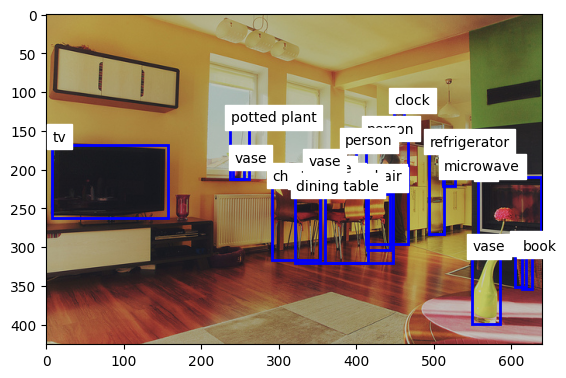

In [11]:
image_name = "/content/val2017/000000000139.jpg"
image_id = int(image_name.split("/")[-1].split(".")[0])
image = plt.imread(image_name)

image_anns = image_ids_ann[image_id]
for img_ann in image_anns:
  bbox = img_ann['bbox']
  name = category_id_to_name[img_ann['category_id']]
  print(name)
  x = float(bbox[0])
  y = float(bbox[1])
  w = float(bbox[2])
  h = float(bbox[3])

  plt.text(x+1, y-5, name, fontdict={'fontsize': 10.0, 'fontweight': 'medium', 'color':'black', 'backgroundcolor':'white'})

  plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2,edgecolor='blue', facecolor='none', fill=False))

plt.imshow(image)
plt.plot()

In [ ]:
x